In [122]:
import timm

In [123]:
import numpy as np
# import decord
import torch
from decord import cpu, gpu
from torch.utils.data import DataLoader
from decord import VideoReader, VideoLoader
from torchvision.datasets import DatasetFolder
from fvcore.common.checkpoint import Checkpointer

In [ ]:
import os
def LoadPath_flatten_embedding(path):
    # Gói block với size (16, 320, 240, 3)
    vl = VideoLoader([path], ctx=[cpu(0)], shape=(32, 480 ,720 , 3), interval=0, skip=1, shuffle=0)
    temp_array = []
    for batch in vl:
        temp_array.append(torch.from_numpy(batch[0].asnumpy()))
    return torch.stack(temp_array)
        
def LoadPath(path):
    k = path.split('/')[3]
    mode = path.split('/')[5]
    if mode == 'val':
        new_path = path.replace('dataset', 'SL-PTIT-50').replace('val/', '')
    else:
        new_path = path.replace('dataset', 'SL-PTIT-50').replace('train/', '')
    latest_path  = new_path.replace(k, 'trunghm')
    
    if not os.path.exists(latest_path):
        latest_path = latest_path.replace('avi', 'mp4')
    print(latest_path,'=========')
    vr = VideoReader(latest_path, ctx=cpu(0), height=224, width=224)
    data_video = vr.get_batch([np.arange(0, len(vr), 2)]).asnumpy()
    data_video = torch.tensor(data_video)
    T, H, W, C = data_video.shape
    if T <= 32:
        padding_video = torch.zeros(32 - T, H, W, C)
        data_video = torch.cat((data_video, padding_video), dim = 0)
    else:
        data_video = vr.get_batch([np.arange(0, len(vr), 4)]).asnumpy()
        data_video = torch.tensor(data_video)
        T, H, W, C = data_video.shape
        if T > 32:
            data_video = data_video[0:32, :, :, :]
            T = 32
        padding_video = torch.zeros(32 - T, H, W, C)
        data_video = torch.cat((data_video, padding_video), dim = 0)
    return data_video
def checkFile(path):
    if path.endswith(('.mp4', '.avi', '.webm')):
        return True


In [125]:
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, Grayscale, ToPILImage
from torchvision.transforms.v2 import RandomHorizontalFlip
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import save_image
# datasets = LoadDatasets()
def transform_video(datasets):
    # count = 0
    transform_video = Compose([
        RandomHorizontalFlip(p=0.5)
    ])
    datasets = transform_video(datasets)
    check = []
    for data in datasets:
        # count+=1
        k = data.numpy()
        # k/=255
        # k = k.astype(np.uint8)
        k/=255
        transform = Compose([
            ToTensor(),
            Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
            
            # Grayscale(3),
            # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        k = transform(k)          
            # save_image(k, '/home/signlanguage/jupyter_workspace/sign_language_test1/output/image{count}.png'.format(count = str(count)))
        check.append(k)
    results = torch.stack(check)
    return results.to('cuda')
            
def transform_video_val(datasets):
    # count = 0
    check = []
    for data in datasets:
        # count+=1
        k = data.numpy()
        # k/=255
        # k = k.astype(np.uint8)
        k/=255
        transform = Compose([
            ToTensor(),
            Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
            
            # Grayscale(3),
            # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        k = transform(k)          
            # save_image(k, '/home/signlanguage/jupyter_workspace/sign_language_test1/output/image{count}.png'.format(count = str(count)))
        check.append(k)
    results = torch.stack(check)
    return results.to('cuda')

In [126]:
# mean=[0.626 ,0.572 ,0.4905], std=[0.12817, 0.14864, 0.16244]

In [127]:

def LoadDatasets(path, transform_video):
    datasets = DatasetFolder(root = path, loader = LoadPath, transform=transform_video, is_valid_file=checkFile)
    return datasets


In [128]:

    
import argparse
def get_args():
    parser = argparse.ArgumentParser(
        'VideoMAE fine-tuning and evaluation script for action classification',
        add_help=False)
    parser.add_argument(
        '--data_path',
        default='/home/tludemo/sign_language/SSV/ssth/sthv2',
        type=str,
        help='dataset path')
    parser.add_argument(
        '--data_root', default='', type=str, help='dataset path root')
    parser.add_argument(
        '--eval_data_path',
        default=None,
        type=str,
        help='dataset path for evaluation')
    parser.add_argument(
        '--nb_classes',
        default=174,
        type=int,
        help='number of the classification types')
    parser.add_argument(
        '--imagenet_default_mean_and_std', default=True, action='store_true')
    parser.add_argument('--num_segments', type=int, default=1)
    parser.add_argument('--num_frames', type=int, default=32)
    parser.add_argument('--sampling_rate', type=int, default=4)
    parser.add_argument('--sparse_sample', default=False, action='store_true')
    parser.add_argument(
        '--data_set',
        default='Kinetics-400',
        choices=[
            'Kinetics-400', 'Kinetics-600', 'Kinetics-700', 'SSV2', 'UCF101',
            'HMDB51', 'Diving48', 'Kinetics-710', 'MIT', 'SLR'
        ],
        type=str,
        help='dataset')
    parser.add_argument(
        '--fname_tmpl',
        default='img_{:05}.jpg',
        type=str,
        help='filename_tmpl for rawframe dataset')
    parser.add_argument(
        '--start_idx',
        default=1,
        type=int,
        help='start_idx for rwaframe dataset')

    parser.add_argument(
        '--output_dir',
        default='',
        help='path where to save, empty for no saving')
    parser.add_argument(
        '--log_dir', default=None, help='path where to tensorboard log')
    parser.add_argument(
        '--device',
        default='cuda',
        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--auto_resume', action='store_true')
    parser.add_argument(
        '--no_auto_resume', action='store_false', dest='auto_resume')
    parser.set_defaults(auto_resume=True)

    parser.add_argument('--save_ckpt', action='store_true')
    parser.add_argument(
        '--no_save_ckpt', action='store_false', dest='save_ckpt')
    parser.set_defaults(save_ckpt=True)

    parser.add_argument(
        '--start_epoch', default=0, type=int, metavar='N', help='start epoch')
    parser.add_argument(
        '--eval', action='store_true', help='Perform evaluation only')
    parser.add_argument(
        '--validation', action='store_true', help='Perform validation only')
    parser.add_argument('--crop_pct', type=float, default=None)
    parser.add_argument('--short_side_size', type=int, default=224)
    parser.add_argument('--test_num_segment', type=int, default=10)
    parser.add_argument('--test_num_crop', type=int, default=3)
    parser.add_argument(
        '--input_size', default=224, type=int, help='images input size')
    parser.add_argument(
        '--reprob',
        type=float,
        default=0.25,
        metavar='PCT',
        help='Random erase prob (default: 0.25)')
    parser.add_argument(
        '--remode',
        type=str,
        default='pixel',
        help='Random erase mode (default: "pixel")')
    parser.add_argument(
        '--recount',
        type=int,
        default=1,
        help='Random erase count (default: 1)')
    parser.add_argument(
        '--resplit',
        action='store_true',
        default=False,
        help='Do not random erase first (clean) augmentation split')
    parser.add_argument(
        '--color_jitter',
        type=float,
        default=0.4,
        metavar='PCT',
        help='Color jitter factor (default: 0.4)')
    parser.add_argument(
        '--num_sample', type=int, default=2, help='Repeated_aug (default: 2)')
    parser.add_argument(
        '--aa',
        type=str,
        default='rand-m7-n4-mstd0.5-inc1',
        metavar='NAME',
        help=
        'Use AutoAugment policy. "v0" or "original". " + "(default: rand-m7-n4-mstd0.5-inc1)'
    ),
    parser.add_argument(
        '--smoothing',
        type=float,
        default=0.1,
        help='Label smoothing (default: 0.1)')
    parser.add_argument(
        '--train_interpolation',
        type=str,
        default='bicubic',
        help=
        'Training interpolation (random, bilinear, bicubic default: "bicubic")'
    )
    known_args, _ = parser.parse_known_args()
    return parser.parse_args()

In [129]:

# from VideoMAEv2.dataset import build_dataset
# args = get_args()
# args.data_set = 'SSV2'
# print(args)
# dataset_train, args.nb_classes = build_dataset(
#         is_train=True, test_mode=False, args=args)
# dataset_val, _ = build_dataset(
        # is_train=False, test_mode=False, args=args)

In [130]:
# from VideoMAEv2 import utils
# import torch
# num_tasks = utils.get_world_size()
# global_rank = utils.get_rank()

# sampler_train = torch.utils.data.DistributedSampler(
#     dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True)
# sampler_val = torch.utils.data.SequentialSampler(dataset_val)

In [131]:
# import pandas as pd
# import os
# train_csv = '/home/tludemo/trunghm/dataset/train.csv'
# val_csv = '/home/tludemo/trunghm/dataset/test.csv'
# train = pd.read_csv(train_csv)
# val_data = pd.read_csv(val_csv)
# for row, val in val_data.iterrows():
#     # if not os.path.exists(path['path']):
#     # print(val)
#     # /home/tludemo/trunghm/SL-PTIT-50/an/N13_an_0.avi
#     if not os.path.exists('/home/tludemo/sign_language/dataset/val/{}'.format(val['label'])):
#          os.makedirs('/home/tludemo/sign_language/dataset/val/{}'.format(val['label']))
#     os.symlink('/home/tludemo/trunghm/SL-PTIT-50/{}.avi'.format(val['filepath'].split('.')[0]), '/home/tludemo/sign_language/dataset/val/{}.avi'.format(val['filepath'].split('.')[0]), target_is_directory=True)
# # os.symlink('/home/tludemo/trunghm/dataset/train', '/home/tludemo/sign_language/dataset/train', target_is_directory=True)

In [132]:
# multiple_samples_collate
# from functools import partial
# collate_func = partial(utils.multiple_samples_collate, fold=False)
# data_loader_train = torch.utils.data.DataLoader(
#         dataset_train,
#         sampler=sampler_train,
#         batch_size=4,
#         num_workers=3,
#         pin_memory=True,
#         drop_last=True,
#         collate_fn=collate_func,
#         persistent_workers=True)
# data_loader_val = torch.utils.data.DataLoader(
#         dataset_val,
#         sampler=sampler_val,
#         batch_size=int(1.5 * 16),
#         num_workers=3,
#         pin_memory=True,
#         drop_last=False,
#         persistent_workers=True)

In [133]:
dataset_train = LoadDatasets(path = '/home/tludemo/sign_language/dataset/train', transform_video=transform_video_val)
dataset_val = LoadDatasets(path = '/home/tludemo/sign_language/dataset/val', transform_video=transform_video_val)

In [134]:
# print(len(dataset_train.classes))

In [135]:
train_batch_datasets = DataLoader(dataset_train, batch_size=6, shuffle=True)
val_batch_datasets = DataLoader(dataset_val, batch_size=1, shuffle=False)


In [136]:
import torch.nn as nn
import torch

class BasicConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv3d, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              bias=False)  # verify bias false

        # verify defalt value in sonnet
        self.bn = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_3b(nn.Module):
    def __init__(self):
        super(Mixed_3b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(192, 64, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(192, 96, kernel_size=1, stride=1),
            BasicConv3d(96, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(192, 16, kernel_size=1, stride=1),
            BasicConv3d(16, 32, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(192, 32, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)

        return out


class Mixed_3c(nn.Module):
    def __init__(self):
        super(Mixed_3c, self).__init__()
        self.branch0 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
            BasicConv3d(128, 192, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(256, 32, kernel_size=1, stride=1),
            BasicConv3d(32, 96, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(256, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4b(nn.Module):
    def __init__(self):
        super(Mixed_4b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(480, 192, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(480, 96, kernel_size=1, stride=1),
            BasicConv3d(96, 208, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(480, 16, kernel_size=1, stride=1),
            BasicConv3d(16, 48, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(480, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4c(nn.Module):
    def __init__(self):
        super(Mixed_4c, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 160, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
            BasicConv3d(112, 224, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            BasicConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4d(nn.Module):
    def __init__(self):
        super(Mixed_4d, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
            BasicConv3d(128, 256, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            BasicConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4e(nn.Module):
    def __init__(self):
        super(Mixed_4e, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 144, kernel_size=1, stride=1),
            BasicConv3d(144, 288, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 32, kernel_size=1, stride=1),
            BasicConv3d(32, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4f(nn.Module):
    def __init__(self):
        super(Mixed_4f, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(528, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(528, 160, kernel_size=1, stride=1),
            BasicConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(528, 32, kernel_size=1, stride=1),
            BasicConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(528, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_5b(nn.Module):
    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(832, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 160, kernel_size=1, stride=1),
            BasicConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 32, kernel_size=1, stride=1),
            BasicConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_5c(nn.Module):
    def __init__(self):
        super(Mixed_5c, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(832, 384, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 192, kernel_size=1, stride=1),
            BasicConv3d(192, 384, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 48, kernel_size=1, stride=1),
            BasicConv3d(48, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

class I3D(nn.Module):

    def __init__(self, num_classes=400, dropout_drop_prob = 0.5, input_channel = 3, spatial_squeeze=True):
        super(I3D, self).__init__()
        self.features = nn.Sequential(
            BasicConv3d(input_channel, 64, kernel_size=7, stride=2, padding=3), # (64, 32, 112, 112)
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),  # (64, 32, 56, 56)
            BasicConv3d(64, 64, kernel_size=1, stride=1), # (64, 32, 56, 56)
            BasicConv3d(64, 192, kernel_size=3, stride=1, padding=1),  # (192, 32, 56, 56)
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),  # (192, 32, 28, 28)
            Mixed_3b(), # (256, 32, 28, 28)
            Mixed_3c(), # (480, 32, 28, 28)
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)), # (480, 16, 14, 14)
            Mixed_4b(),# (512, 16, 14, 14)
            Mixed_4c(),# (512, 16, 14, 14)
            Mixed_4d(),# (512, 16, 14, 14)
            Mixed_4e(),# (528, 16, 14, 14)
            Mixed_4f(),# (832, 16, 14, 14)
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0)), # (832, 8, 7, 7)
            Mixed_5b(), # (832, 8, 7, 7)
            Mixed_5c(), # (1024, 8, 7, 7)
            # nn.AvgPool3d(kernel_size=(2, 7, 7), stride=1),# (1024, 8, 1, 1)
            # nn.Dropout3d(dropout_drop_prob),
            # nn.Conv3d(1024, num_classes, kernel_size=1, stride=1, bias=True),# (400, 8, 1, 1)
        )
        # self.spatial_squeeze = spatial_squeeze
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.transpose(1, 2)
        logits = self.features(x)

        # if self.spatial_squeeze:
        #     logits = logits.squeeze(3)
        #     logits = logits.squeeze(3)

        # averaged_logits = torch.mean(logits, 2)
        # predictions = self.softmax(averaged_logits)

        return logits
       
       
       
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.utils.model_zoo as model_zoo
# import torch.nn.functional as F


# __all__ = ['i3d']

# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
# }


# def BasicConv3d(in_planes, out_planes, kernel_size, stride=(1, 1, 1), padding=(0, 0, 0),
#                 bias=False):
#     """3x3 convolution with padding"""
#     return nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size,
#                      stride=stride, padding=padding, bias=bias)


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, inplanes, planes, stride=(1, 1, 1), padding=0, downsample=None):
#         super(BasicBlock, self).__init__()

#         self.conv1 = BasicConv3d(inplanes, planes, kernel_size=(3, 3, 3),
#                                  stride=stride, padding=padding, bias=False)
#         self.bn1 = nn.BatchNorm3d(planes)
#         self.relu1 = nn.ReLU(inplace=True)

#         self.conv2 = BasicConv3d(planes, planes, kernel_size=3,
#                                  stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm3d(planes)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu2(out)

#         return out


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, inplanes, planes, stride=1, padding=0, downsample=None):
#         super(Bottleneck, self).__init__()
#         self.conv1 = BasicConv3d(inplanes, planes, kernel_size=(1, 1, 1),
#                                  stride=(1, 1, 1), padding=(0, 0, 0), bias=False)
#         self.bn1 = nn.BatchNorm3d(planes)
#         self.relu1 = nn.ReLU(inplace=True)
#         self.conv2 = BasicConv3d(planes, planes, kernel_size=(3, 3, 3),
#                                  stride=stride, padding=padding, bias=False)
#         self.bn2 = nn.BatchNorm3d(planes)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.conv3 = BasicConv3d(planes, planes * self.expansion, kernel_size=(1, 1, 1),
#                                  stride=(1, 1, 1), padding=(0, 0, 0), bias=False)
#         self.bn3 = nn.BatchNorm3d(planes * self.expansion)
#         self.relu3 = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu2(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu3(out)

#         return out


# class I3D(nn.Module):
#     def __init__(self, depth, num_classes=1000, dropout=0.5, without_t_stride=False,
#                  zero_init_residual=False):
#         super(I3D, self).__init__()
#         layers = {
#             18: [2, 2, 2, 2],
#             34: [3, 4, 6, 3],
#             50: [3, 4, 6, 3],
#             101: [3, 4, 23, 3],
#             152: [3, 8, 36, 3]}[depth]
#         block = BasicBlock if depth < 50 else Bottleneck
#         self.depth = depth
#         self.without_t_stride = without_t_stride
#         self.inplanes = 64
#         self.t_s = 1 if without_t_stride else 2
#         self.conv1 = BasicConv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3),
#                                  bias=False)
#         self.bn1 = nn.BatchNorm3d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))

#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv3d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm3d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.001)
#                 nn.init.constant_(m.bias, 0)
#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)
    
#     def mean(self, modality='rgb'):
#         return [0.485, 0.456, 0.406] if modality == 'rgb' else [0.5]

#     def std(self, modality='rgb'):
#         return [0.229, 0.224, 0.225] if modality == 'rgb' else [np.mean([0.229, 0.224, 0.225])]
    
#     @property
#     def network_name(self):
#         name = 'i3d-resnet-{}'.format(self.depth)

#         if not self.without_t_stride:
#             name += '-ts'.format(self.depth)
#         return name

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 BasicConv3d(self.inplanes, planes * block.expansion, kernel_size=(1, 1, 1),
#                             stride=(self.t_s if stride == 2 else 1, stride, stride)),
#                 nn.BatchNorm3d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride=(self.t_s if stride == 2 else 1, stride, stride),
#                             padding=1, downsample=downsample))

#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes, padding=1))

#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         return x

In [137]:
from timm.models.layers import to_2tuple

class BackboneI3D(torch.nn.Module):
    def __init__(self, model, weight_pretrained):
        super().__init__()
        self.extract_feature = model
        self.checkpoint = torch.load(weight_pretrained) 
        # "features.18.weight", "features.18.bias".
        # print(self.checkpoint.keys(),'==============')
        del self.checkpoint['features.18.weight']
        del self.checkpoint['features.18.bias']
        print(self.checkpoint.keys())
        self.extract_feature.load_state_dict(self.checkpoint)
    def forward(self, input):
        out = self.extract_feature(input)
        return out
    
class PatchEmbed1(torch.nn.Module):
    def __init__(self, input_shape, embed_dim, patch_size, tubelet_size):
        super().__init__()
        self.input_shape = input_shape
        patch_size = to_2tuple(patch_size) 
        self.conv3d = torch.nn.Conv3d(
            in_channels=1024,
            out_channels=embed_dim,
            kernel_size=(tubelet_size, patch_size[0], patch_size[1]),
            stride=(tubelet_size, patch_size[0], patch_size[1])
            )
    def forward(self, inp):
        out = self.conv3d(inp)
        return out.flatten(2).transpose(1,2)

In [138]:
import torch
import numpy
import torch.nn as nn
from timm.models.registry import register_model
from timm.models.layers import DropPath, to_2tuple
# from .t2t import T2T, get_sinusoid_encoding
from timm.models.vision_transformer import _cfg, Mlp, Block, trunc_normal_
from timm.models.vision_transformer import Attention
# Việc cần làm:
# Xây cros attention => (Q - cls token, k, v-patch token) => linear + dropout
# cros attention block => cros attention + block(attn)??? + mlp
# Xây ViVit => concat patch emb A + cls token B and revert (đã flatten hết patch embed và cls token ra) => cros

class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.wq = nn.Linear(dim, dim, bias=qkv_bias)
        self.wk = nn.Linear(dim, dim, bias=qkv_bias)
        self.wv = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...]).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # B1C -> B1H(C/H) -> BH1(C/H)
        k = self.wk(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # BNC -> BNH(C/H) -> BHN(C/H)
        v = self.wv(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # BNC -> BNH(C/H) -> BHN(C/H)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # BH1(C/H) @ BH(C/H)N -> BH1N
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, 1, C)   # (BH1N @ BHN(C/H)) -> BH1(C/H) -> B1H(C/H) -> B1C
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=None, has_mlp=True):
        super().__init__()
        # self.norm1 = norm_layer(dim)
        self.attn = CrossAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            # self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x[:, 0:1, ...] + self.drop_path(self.attn(x))
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(x))

        return x


class MultiScaleBlock(nn.Module):

    def __init__(self, dim, patches, depth, num_heads, mlp_ratio, qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=None):
        super().__init__()

        num_branches = len(dim)
        self.num_branches = num_branches
        # different branch could have different embedding size, the first one is the base
        self.blocks = nn.ModuleList()
        for d in range(num_branches):
            tmp = []
            for i in range(depth[d]):
                tmp.append(
                    Block(dim=dim[d], num_heads=num_heads[d], mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias, 
                          drop=drop, attn_drop=attn_drop, drop_path=drop_path[i], norm_layer=nn.LayerNorm))
            if len(tmp) != 0:
                self.blocks.append(nn.Sequential(*tmp))

        if len(self.blocks) == 0:
            self.blocks = None

        self.projs = nn.ModuleList()
        for d in range(num_branches):
            if dim[d] == dim[(d+1) % num_branches] and False:
                tmp = [nn.Identity()]
            else:
                tmp = [act_layer(), nn.Linear(dim[d], dim[(d+1) % num_branches])]
            self.projs.append(nn.Sequential(*tmp))

        self.fusion = nn.ModuleList()
        for d in range(num_branches):
            d_ = (d+1) % num_branches
            nh = num_heads[d_]
            if depth[-1] == 0:  # backward capability:
                self.fusion.append(CrossAttentionBlock(dim=dim[d_], num_heads=nh, mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                       drop=drop, attn_drop=attn_drop, drop_path=drop_path[-1], norm_layer=nn.LayerNorm,
                                                       has_mlp=False))
            else:
                tmp = []
                for _ in range(depth[-1]):
                    tmp.append(CrossAttentionBlock(dim=dim[d_], num_heads=nh, mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                   drop=drop, attn_drop=attn_drop, drop_path=drop_path[-1], norm_layer=nn.LayerNorm,
                                                   has_mlp=False))
                self.fusion.append(nn.Sequential(*tmp))

        self.revert_projs = nn.ModuleList()
        for d in range(num_branches):
            if dim[(d+1) % num_branches] == dim[d] and False:
                tmp = [nn.Identity()]
            else:
                tmp = [ act_layer(), nn.Linear(dim[(d+1) % num_branches], dim[d])]
            self.revert_projs.append(nn.Sequential(*tmp))

    def forward(self, x):
        outs_b = [block(x_) for x_, block in zip(x, self.blocks)]
        # only take the cls token out
        proj_cls_token = [proj(x[:, 0:1]) for x, proj in zip(outs_b, self.projs)]
        # cross attention
        outs = []
        for i in range(self.num_branches):
            tmp = torch.cat((proj_cls_token[i], outs_b[(i + 1) % self.num_branches][:, 1:, ...]), dim=1)
            tmp = self.fusion[i](tmp)
            reverted_proj_cls_token = self.revert_projs[i](tmp[:, 0:1, ...])
            tmp = torch.cat((reverted_proj_cls_token, outs_b[i][:, 1:, ...]), dim=1)
            outs.append(tmp)
        return outs



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=(224, 224), patch_size=(12, 16), tubelet =(4, 8),  in_chans=3, num_classes=1000, embed_dim=(192, 384), depth=([1, 3, 1], [1, 3, 1], [1, 3, 1]),
                 num_heads=(6, 12), mlp_ratio=(2., 2., 4.), qkv_bias=False, qk_scale=None, drop_rate=0.5, attn_drop_rate=0.1,
                 drop_path_rate=0.2, hybrid_backbone=None, norm_layer=None, weight_pretrained=None, multi_conv=False):
        super().__init__()
        self.gradients = None
        self.activations = None
        self.pretrained_weight = weight_pretrained
        self.num_classes = num_classes
        if not isinstance(img_size, list):
            img_size = to_2tuple(img_size)
        self.img_size = img_size
        num_patches = (196, 18)
        self.num_branches = len(patch_size)
        self.patch_embed = nn.ModuleList()
        if hybrid_backbone is None:
            self.InceptionI3d = I3D(self.num_classes)
            self.backbone = BackboneI3D(model = self.InceptionI3d, weight_pretrained = self.pretrained_weight)
            self.pos_embed = nn.ParameterList([nn.Parameter(torch.zeros(1, 1+num_patches[i], embed_dim[i])) for i in range(self.num_branches)])
            for im_s, p, d, tubelet in zip(img_size, patch_size, embed_dim, tubelet):
                self.patch_embed.append(PatchEmbed1(input_shape=im_s, embed_dim=d, patch_size=p, tubelet_size=tubelet))
        self.cls_token = nn.ParameterList([nn.Parameter(torch.zeros(1, 1, embed_dim[i])) for i in range(self.num_branches)])
        self.pos_drop = nn.Dropout(p=0.5)

        total_depth = sum([sum(x[-2:]) for x in depth])
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_depth)]  # stochastic depth decay rule
        dpr_ptr = 0
        self.blocks = nn.ModuleList()
        for idx, block_cfg in enumerate(depth):
            curr_depth = max(block_cfg[:-1]) + block_cfg[-1]
            dpr_ = dpr[dpr_ptr:dpr_ptr+curr_depth]
            blk = MultiScaleBlock(embed_dim, num_patches, block_cfg, num_heads=num_heads, mlp_ratio=mlp_ratio,
                                  qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr_,
                                  norm_layer=nn.LayerNorm)
            dpr_ptr += curr_depth
            self.blocks.append(blk)
        self.num_classes = num_classes
        self.drop_out = nn.Dropout(p = 0.5)
        self.norm = nn.ModuleList([norm_layer(embed_dim[i]) for i in range(self.num_branches)])
        self.head = nn.ModuleList([nn.Linear(embed_dim[i], num_classes) if num_classes > 0 else nn.Identity() for i in range(self.num_branches)])
        # self.head_auxilary =  nn.ModuleList([nn.Linear(embed_dim[i], num_classes) if num_classes > 0 else nn.Identity() for i in range(self.num_branches)])
        for i in range(self.num_branches):
            if self.pos_embed[i].requires_grad:
                trunc_normal_(self.pos_embed[i], std=.02)
            trunc_normal_(self.cls_token[i], std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        out = {'cls_token'}
        if self.pos_embed[0].requires_grad:
            out.add('pos_embed')
        return out

    def get_classifier(self):
        return self.head

    def activations_hook(self, grad):
#         print('ghudfidfhids')
        self.gradients.append(grad)
#         print(self.gradients)
        
    # method for the gradient extraction
    def get_activations_gradient(self):
#         print(self.gradients)
        # print(self.gradients)
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        B, T, C, H, W = x.shape
        xs = []
        x=x.transpose(1,2)
        x_ = self.backbone(x)
        activations = []
        for i in range(self.num_branches):
            # x = torch.nn.functional.interpolate(x, size=(C, self.img_size[i], self.img_size[i]), mode='nearest-exact') if H != self.img_size[i] else x
            # x_ = self.backbone(x_)
            tmp = self.patch_embed[i](x_)
            cls_tokens = self.cls_token[i].expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
            tmp = torch.cat((cls_tokens, tmp), dim=1)

            tmp = tmp + self.pos_embed[i]
            tmp = self.pos_drop(tmp)
            xs.append(tmp)
        for blk in self.blocks:
            torch.cuda.empty_cache()
            xs = blk(xs)
        # NOTE: was before branch token section, move to here to assure all branch token are before layer norm
        xs = [self.norm[i](x) for i, x in enumerate(xs)]
        [activations.append(x) for x in xs]
        
        return activations

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B, T, C, H, W = x.shape
        xs = []
        x=x.transpose(1,2)
        x_ = self.backbone(x)
        # print(x_.shape,'==================')
        for i in range(self.num_branches):
            # x = torch.nn.functional.interpolate(x, size=(C, self.img_size[i], self.img_size[i]), mode='nearest-exact') if H != self.img_size[i] else x
            # x_ = self.backbone(x_)
            tmp = self.patch_embed[i](x_)
            cls_tokens = self.cls_token[i].expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
            tmp = torch.cat((cls_tokens, tmp), dim=1)

            tmp = tmp + self.pos_embed[i]
            tmp = self.pos_drop(tmp)
            xs.append(tmp)
        for blk in self.blocks:
            torch.cuda.empty_cache()
            xs = blk(xs)
        # NOTE: was before branch token section, move to here to assure all branch token are before layer norm
        xs = [self.norm[i](x) for i, x in enumerate(xs)]
        cnt=0
        for x in xs:
            h = x.register_hook(self.activations_hook) 
        out = [x[:, 0] for x in xs]
        return out

    def forward(self, x):
        self.gradients = []
        # x = x.transpose(1, 2)
        feats = self.forward_features(x)
        # ce_logits = torch.cat((feats[0], feats[1]), dim = 1)
        # ce_logits = self.global_head(ce_logits)
        # pre_cls_small = torch.squeeze(pre_cls_small)
        # pre_cls_large = torch.squeeze(pre_cls_large)
        # pre_cls = []
        # pre_cls.append(pre_cls_small)
        # pre_cls.append(pre_cls_large)
        # ce_logits_auxilary = [self.head_auxilary[i](x) for i, x in enumerate(pre_cls)]
        ce_logits = [self.head[i](x) for i, x in enumerate(feats)]
        # ce_logits = torch.squeeze(ce_logits, dim = 1)
        ce_logits = torch.mean(torch.stack(ce_logits, dim=0), dim=0)
        # self.get_activations(ce_logits)
        h = ce_logits.register_hook(self.activations_hook)
        return ce_logits

In [ ]:
from timm.models import create_model
from timm.models.vision_transformer import _cfg
from functools import partial
@register_model
def vit(pretrained = False, **kwargs):
    model = VisionTransformer(
        img_size=[224, 224],
        patch_size=[1, 2],
        tubelet =[1, 2],
        in_chans=3,
        num_classes=97,
        embed_dim=[224, 448],
        depth=[[1, 6, 0], [1, 6, 0], [1, 6, 0]],
        num_heads=[7, 7],
        mlp_ratio=[3, 3, 1],
        qkv_bias= True,
        weight_pretrained='/home/tludemo/sign_language/rgb_imagenet.pkl',
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg
    return model


: 

In [140]:
# import models
vit = create_model(
    model_name= 'vit',
    pretrained=False,    
)
print(vit)

/tmp/ipykernel_2399799/1599191208.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.checkpoint = torch.load(weight_pretrained)


odict_keys(['features.0.conv.weight', 'features.0.bn.weight', 'features.0.bn.bias', 'features.0.bn.running_mean', 'features.0.bn.running_var', 'features.2.conv.weight', 'features.2.bn.weight', 'features.2.bn.bias', 'features.2.bn.running_mean', 'features.2.bn.running_var', 'features.3.conv.weight', 'features.3.bn.weight', 'features.3.bn.bias', 'features.3.bn.running_mean', 'features.3.bn.running_var', 'features.5.branch0.0.conv.weight', 'features.5.branch0.0.bn.weight', 'features.5.branch0.0.bn.bias', 'features.5.branch0.0.bn.running_mean', 'features.5.branch0.0.bn.running_var', 'features.5.branch1.0.conv.weight', 'features.5.branch1.0.bn.weight', 'features.5.branch1.0.bn.bias', 'features.5.branch1.0.bn.running_mean', 'features.5.branch1.0.bn.running_var', 'features.5.branch1.1.conv.weight', 'features.5.branch1.1.bn.weight', 'features.5.branch1.1.bn.bias', 'features.5.branch1.1.bn.running_mean', 'features.5.branch1.1.bn.running_var', 'features.5.branch2.0.conv.weight', 'features.5.bran

In [141]:
import io
import os
import time
from collections import defaultdict, deque
import datetime

import torch
import torch.distributed as dist


import io
import os
import time
from collections import defaultdict, deque
import datetime
import tempfile
import logging

import torch
import torch.distributed as dist
# from fvcore.common.checkpoint import Checkpointer


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)





class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = [
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}'
        ]
        if torch.cuda.is_available():
            log_msg.append('max mem: {memory:.0f}')
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def _load_checkpoint_for_ema(model_ema, checkpoint):
    """
    Workaround for ModelEma._load_checkpoint to accept an already-loaded object
    """
    mem_file = io.BytesIO()
    torch.save(checkpoint, mem_file)
    mem_file.seek(0)
    print(mem_file)
    model_ema._load_checkpoint(mem_file)


def load_checkpoint(model, state_dict, mode=None):

    # reuse Checkpointer in fvcore to support flexible loading
    ckpt = Checkpointer(model, save_to_disk=False)
    logging.basicConfig()
    ckpt.logger.setLevel(logging.INFO)
    # since Checkpointer requires the weight to be put under `model` field, we need to save it to disk
    tmp_path = tempfile.NamedTemporaryFile('w+b')
    torch.save({'model': state_dict}, tmp_path.name)
    ckpt.load(tmp_path.name)

def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [142]:
import math
from typing import Iterable, Optional
import torch
# from collections import OrderedDict
from timm.data import Mixup
from timm.utils import accuracy
from timm.utils import ModelEma
# from einops import rearrange
from copy import deepcopy


def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, loss_scaler, max_norm: float = 0,
                    mixup_fn: Optional[Mixup] = None,
                    world_size: int = 1, distributed: bool = True, amp=True,
                    finetune=False, model_ema=None):
    if finetune:
        model.train(not finetune)
    else:
        model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    # precision_matrices = OrderedDict()
    params = {n: p for n, p in model.named_parameters() if p.requires_grad}
    precision_matrices = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        precision_matrices[n] = p.data
    # for data_iter_step, (samples, targets, _, _) in enumerate(
    #         metric_logger.log_every(data_loader, print_freq, header)):
    inputs = 0
    for samples,targets in metric_logger.log_every(data_loader, 100, header):
        batch_size = targets.size(0)
        inputs = samples
        samples = samples.to(device, non_blocking=True).transpose(1, 2)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, targets = mixup_fn(samples, targets)

        with torch.cuda.amp.autocast(enabled=amp):
            outputs = model(samples)
            loss = criterion(outputs, targets)
            loss_value = loss.item()

            if not math.isfinite(loss_value):
                print("Loss is {}, stopping training".format(loss_value))
                raise ValueError("Loss is {}, stopping training".format(loss_value))

            optimizer.zero_grad()
            if model_ema is not None:
                model_ema.update(model)
            # this attribute is added by timm on one optimizer (adahessian)
            is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order

            if amp:
                loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)
            else:
                loss.backward(create_graph=is_second_order)
                if max_norm is not None and max_norm != 0.0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                for n, p in model.named_parameters():
                    if p.grad is not None:
                       precision_matrices[n].data += (p.grad.data ** 2 / len(data_loader))
                    #    print(precision_matrices[n].mean())
                
                optimizer.step()
            
        torch.cuda.synchronize()

        metric_logger.update(loss=loss_value)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        # acc1, acc2 = accuracy(outputs, targets, topk=(1, 2))
        # metric_logger.meters['acc1'].update(acc1.item(), n=1)
        # metric_logger.meters['acc2'].update(acc2.item(), n=1)
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print(
        'loss {losses.global_avg:.3f}'
        .format(
            losses=metric_logger.loss))

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}, precision_matrices, inputs

In [143]:
# from torcheval.metrics import MulticlassAUROC
# roc_auc = MulticlassAUROC(num_classes = 97)

In [144]:
import numpy as np
# from sklearn import metrics
@torch.no_grad()
def evaluate(test_data_loader, model, device, amp=False):
    criterion = nn.CrossEntropyLoss()

    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    # switch to evaluation mode
    model.eval()
    # model.train()
    outputs = []
    targets = []
    pred = []
    gt = []
    for batch in metric_logger.log_every(test_data_loader, 100, header):
        images = batch[0]
        target = batch[1]
        samples = images.to(device, non_blocking=True).transpose(1, 2)
        targets = target.to(device, non_blocking=True)
        samples = samples.float()
        # compute output
        with torch.cuda.amp.autocast(enabled=amp):
            outputs = model.forward(samples)
            loss = criterion(outputs, targets)
        # roc_auc.update(outputs, target)
        loss_value = loss.item()
        metric_logger.update(loss=loss_value)
        acc1, acc2 = accuracy(outputs, targets, topk=(1, 2))
        metric_logger.meters['acc1'].update(acc1.item(), n=1)
        metric_logger.meters['acc2'].update(acc2.item(), n=1)
       
    with open('out.txt', 'a') as f:
        f.write( '* Acc@1 {top1.global_avg:.3f} Acc@2 {top2.global_avg:.3f} loss {losses.global_avg:.3f}'
        .format(
            top1=metric_logger.acc1,
            top2=metric_logger.acc2,
            losses=metric_logger.loss))

    metric_logger.synchronize_between_processes()
    print(
        '* Acc@1 {top1.global_avg:.3f} Acc@2 {top2.global_avg:.3f} loss {losses.global_avg:.3f}'
        .format(
            top1=metric_logger.acc1,
            top2=metric_logger.acc2,
            losses=metric_logger.loss))
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [145]:
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
import numpy as np

@torch.no_grad()
def evaluate_F1(test_data_loader, model, device, amp=False):
    criterion = nn.CrossEntropyLoss()

    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    # Switch to evaluation mode
    model.eval()

    all_targets = []
    all_predictions = []

    for batch in metric_logger.log_every(test_data_loader, 100, header):
        images = batch[0]
        targets = batch[1]

        samples = images.to(device, non_blocking=True).float().transpose(1, 2)
        targets = targets.to(device, non_blocking=True)

        # Compute output
        with torch.cuda.amp.autocast(enabled=amp):
            outputs = model.forward(samples)
            loss = criterion(outputs, targets)
        
        # Update loss
        loss_value = loss.item()
        metric_logger.update(loss=loss_value)

        # Compute accuracy (already provided in your code)
        acc1, acc2 = accuracy(outputs, targets, topk=(1, 2))
        metric_logger.meters['acc1'].update(acc1.item(), n=1)
        metric_logger.meters['acc2'].update(acc2.item(), n=1)

        # Get predictions and true labels
        _, predictions = outputs.max(1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    # Print metrics
    print(
        '* Acc@1 {top1.global_avg:.3f} Acc@2 {top2.global_avg:.3f} loss {losses.global_avg:.3f}'
        .format(
            top1=metric_logger.acc1,
            top2=metric_logger.acc2,
            losses=metric_logger.loss))
    print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')

    # Save results to file
    with open('out.txt', 'a') as f:
        f.write(
            f'* Acc@1 {metric_logger.acc1.global_avg:.3f} Acc@2 {metric_logger.acc2.global_avg:.3f} '
            f'loss {metric_logger.loss.global_avg:.3f}\n'
            f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}\n'
        )

    # Return all metrics
    metrics = {k: meter.global_avg for k, meter in metric_logger.meters.items()}
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1
    return metrics


In [146]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def evaluate_with_average_roc(test_data_loader, model, device, amp=False):
    criterion = torch.nn.CrossEntropyLoss()

    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    # Switch to evaluation mode
    model.eval()

    all_targets = []
    all_outputs = []

    for batch in metric_logger.log_every(test_data_loader, 100, header):
        images = batch[0]
        targets = batch[1]

        images = images.to(device, non_blocking=True).float().transpose(1, 2)
        targets = targets.to(device, non_blocking=True)

        # Compute output
        with torch.cuda.amp.autocast(enabled=amp):
            outputs = model(images)
            loss = criterion(outputs, targets)

        # Update loss
        loss_value = loss.item()
        metric_logger.update(loss=loss_value)

        # Store outputs and targets
        all_outputs.extend(outputs.softmax(dim=1).cpu().numpy())  # Convert to probabilities
        all_targets.extend(targets.cpu().numpy())

    # Convert lists to numpy arrays
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)

    # Binarize targets for ROC calculation
    num_classes = all_outputs.shape[1]
    all_targets_binarized = np.eye(num_classes)[all_targets]

    # Compute micro-average ROC curve and AUC
    # fpr, tpr, _ = roc_curve(all_targets_binarized.ravel(), all_outputs.ravel())
    # roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    # plt.figure(figsize=(10, 8))
    # plt.plot(fpr, tpr, label=f'Average ROC (AUC = {roc_auc:.2f})', lw=2)
    # plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guessing
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Average Receiver Operating Characteristic (ROC)')
    # plt.legend(loc='lower right')
    # plt.grid()
    # plt.show()

    # Print metrics
    print(
        '* Acc@1 {top1.global_avg:.3f} Acc@2 {top2.global_avg:.3f} loss {losses.global_avg:.3f}'
        .format(
            top1=metric_logger.acc1,
            top2=metric_logger.acc2,
            losses=metric_logger.loss))
    print(f'Average AUC: {roc_auc:.3f}')

    # return {k: meter.global_avg for k, meter in metric_logger.meters.items(), "average_auc": roc_auc}


In [147]:
import argparse
def get_args_parser():
    parser = argparse.ArgumentParser('CrossViT training and evaluation script', add_help=False)
    parser.add_argument('--batch-size', default=2, type=int)
    parser.add_argument('--epochs', default=100, type=int)
        # Optimizer parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt-eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt-betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--clip-grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--weight-decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')
    # Learning rate schedule parameters
    parser.add_argument('--sched', default='cosine', type=str, metavar='SCHEDULER',
                        help='LR scheduler (default: "cosine"')
    parser.add_argument('--lr', type=float, default=5e-4, metavar='LR',
                        help='learning rate (default: 5e-4)')
    parser.add_argument('--lr-noise', type=float, nargs='+', default=None, metavar='pct, pct',
                        help='learning rate noise on/off epoch percentages')
    parser.add_argument('--lr-noise-pct', type=float, default=0.67, metavar='PERCENT',
                        help='learning rate noise limit percent (default: 0.67)')
    parser.add_argument('--lr-noise-std', type=float, default=1.0, metavar='STDDEV',
                        help='learning rate noise std-dev (default: 1.0)')
    parser.add_argument('--warmup-lr', type=float, default=1e-6, metavar='LR',
                        help='warmup learning rate (default: 1e-6)')
    parser.add_argument('--min-lr', type=float, default=1e-5, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')

    parser.add_argument('--decay-epochs', type=float, default=30, metavar='N',
                        help='epoch interval to decay LR')
    parser.add_argument('--warmup-epochs', type=int, default=3, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--cooldown-epochs', type=int, default=10, metavar='N',
                        help='epochs to cooldown LR at min_lr, after cyclic schedule ends')
    parser.add_argument('--patience-epochs', type=int, default=10, metavar='N',
                        help='patience epochs for Plateau LR scheduler (default: 10')
    parser.add_argument('--decay-rate', '--dr', type=float, default=0.1, metavar='RATE',
                        help='LR decay rate (default: 0.1)')
     # * Mixup params
    parser.add_argument('--mixup', type=float, default=0.8,
                        help='mixup alpha, mixup enabled if > 0. (default: 0.8)')
    parser.add_argument('--cutmix', type=float, default=1.0,
                        help='cutmix alpha, cutmix enabled if > 0. (default: 1.0)')
    parser.add_argument('--cutmix-minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup-prob', type=float, default=1.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup-switch-prob', type=float, default=0.5,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--smoothing', type=float, default=0.1, 
                         help='Label smoothing (default: 0.1)')
    parser.add_argument('--mixup-mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')
    parser.add_argument('-f')
    return parser

In [148]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [149]:
# Define normalization values (used during preprocessing)
# mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)  # Shape for broadcasting
# std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)

def reverse_transform_video(video_tensor):
    """
    Reverses the transformation applied to the video tensor.
    
    Input: video_tensor of shape (T, C, H, W)  (Transformed video)
    Output: video_frames of shape (T, H, W, C) (Original format)
    """
    video_tensor = video_tensor[0]
    video_tensor = video_tensor.permute(0, 2, 3, 1).cpu()  # Convert (T, C, H, W) -> (T, H, W, C)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 1, 3)  # (1, 1, 1, 3) for broadcasting
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 1, 3)
    # Denormalize
    video_tensor = video_tensor * std + mean  # Reverse normalization
    
    # Convert to NumPy and scale back to [0, 255]
    video_numpy = (video_tensor.numpy() * 255).clip(0, 255).astype(np.uint8)  # (T, H, W, C)

    return video_numpy  # Return reconstructed video as numpy array

In [ ]:

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy        # roc_auc.update(outputs, target)

from timm.optim import create_optimizer_v2
from timm.utils import NativeScaler, ModelEma
from timm.scheduler import create_scheduler
import matplotlib.pyplot as plt
import json

def main(args, tuning = True):
    device = 'cuda'
    device = torch.device(device)
    criterion = LabelSmoothingCrossEntropy(0.1)
    # criterion = SoftTargetCrossEntropy()
    # mixup_fn = Mixup(
    #     mixup_alpha=args.mixup, cutmix_alpha=args.cutmix, cutmix_minmax=args.cutmix_minmax,
    #     prob=args.mixup_prob, switch_prob=args.mixup_switch_prob, mode=args.mixup_mode,
    #     label_smoothing=args.smoothing, num_classes=97)
    optimizer = create_optimizer_v2(
            model = vit,
            optimizer_name='adamw',
            filter_bias_and_bn=True,
            learning_rate = 5e-6,
            weight_decay = 0.05,
            momentum= 0.99,
            eps = 1e-8,
        )
    model_ema = ModelEma(
            vit,
            decay= 0.9999,
            device='cuda:0',
            resume='')
    lr_scheduler, _ = create_scheduler(args, optimizer= optimizer)
    max_accuracy = 0
    start_epoch = 0
    vit.to('cuda')
    loss_scaler = NativeScaler()
    if tuning == True:
        checkpoint = torch.load(f = '/home/tludemo/sign_language/weight/best_model_demo.pt', map_location='cpu')
        load_checkpoint(vit, checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        start_epoch = checkpoint['epoch']
        max_accuracy = checkpoint['max_accuracy']
        print(max_accuracy)
        model_ema = model_ema.update(vit)
        optimizer_to(optimizer, 'cuda:0')
        tuning = False
    vit.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'
    cnt = 0
    for batch in metric_logger.log_every(val_batch_datasets, 100, header):
        cnt += 1
        images = batch[0]
        targets = batch[1]
        
        original_images = reverse_transform_video(images)
        images = images.to(device, non_blocking=True).float().transpose(1, 2)
        targets = targets.to(device, non_blocking=True)

        # Compute output
        with torch.cuda.amp.autocast(enabled=False):
            outputs = vit(images)
    #     vit.zero_grad()
    #     outputs[:,targets].backward()
    #     gradients = vit.get_activations_gradient()
    #     test_grad = gradients[1][0][0,:]
    #     test_grad = test_grad[..., None]
    #     # print(test_grad.shape)
    #     # print(test_grad.shape)prin
    #     # pooled_gradients = torch.mean(test_grad, dim=[2, 3])
        
    #     # print(pooled_gradients.shape)
        

    #     # pool the gradients across the channels
    #     # for grad in gradients:
    #     #     print(grad.shape)   
    #     # print(gradients[0].shape)
        
        
    #     activations = vit.get_activations(images)
    #     branch_one = activations[1][:,1:,:].reshape(1, activations[1].shape[2], 2, 3, 3).detach()
    #     channels, n_frames = branch_one.shape[1], branch_one.shape[2]
        
    #     for i in range(channels):
    #         for j in range(n_frames):
                
    #             branch_one[:,i,j,:,:]*= test_grad[i]
    #     heatmap = torch.mean(branch_one, dim=1).squeeze().cpu()
    #     heatmap = np.maximum(heatmap.cpu(),0)
    #     for i in range(n_frames):
    #         heatmap[i]/=torch.max(heatmap[i])
    #     heatmap = heatmap.numpy()
    #     if cnt == 180:
    #         break
    # return heatmap, original_images
    for epoch in range(start_epoch+1 , start_epoch+2):
            _, precision_matrices, inputs = train_one_epoch(model  = vit, criterion=criterion, data_loader=val_batch_datasets, optimizer=optimizer, device=device, epoch=epoch, model_ema=model_ema, mixup_fn =  None, max_norm=args.clip_grad, loss_scaler = loss_scaler, amp=False)
            lr_scheduler.step(epoch)
            val_accuracy = evaluate(test_data_loader=val_batch_datasets, model=vit, device='cuda', amp=False)
            cpu_dict = {key: value.cpu().tolist() for key, value in precision_matrices.items()}
            with open("tensor_data.json", "w") as f:
                json.dump(cpu_dict, f)
            max_accuracy = max(val_accuracy['acc1'], max_accuracy)
            
            if max_accuracy == val_accuracy['acc1']:
                state_dict ={
                    'model': vit.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'args': args,
                    'max_accuracy': max_accuracy,          
                    }
                torch.save(state_dict, 
                    '/home/tludemo/sign_language/weight/test.pt')
            else:
                state_dict ={
                    'model': vit.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'args': args,
                    'va_accuracy': val_accuracy['acc1'],          
                    }
                torch.save(state_dict, 
                    '/home/tludemo/sign_language/weight/a.pt')
    # return vit.get_activations_gradient(), vit.activations, inputs


In [151]:
# if __name__ == '__main__':
parser = argparse.ArgumentParser('CrossViT training and evaluation script', parents=[get_args_parser()])
args, unknown = parser.parse_known_args() 

heatmap, origin_images = main(args)

print(origin_images.shape)    # /home/tludemo/trunghm/SL-PTIT-50/yeu/N5_yeu_15.mp4
    

/tmp/ipykernel_2399799/2721111580.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f = '/home/tludemo/sign_language/weight/best_model_demo.pt', m

/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_0.avi =========


/tmp/ipykernel_2399799/2721111580.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/tmp/ipykernel_2399799/2721111580.py:90: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(),0)


Test:  [   0/2611]  eta: 0:11:34    time: 0.2658  data: 0.1850  max mem: 2196
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_1.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_10.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_2.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_3.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_4.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_5.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_6.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_7.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_8.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N29_an_9.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N31_an_0.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N31_an_1.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N31_an_10.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N31_an_11.avi =========
/home/tludemo/trunghm/SL-PTIT-50/an/N31_an_2.avi =========
/home/tludemo/trunghm/SL-PTIT-50/a

(2, 3, 3)


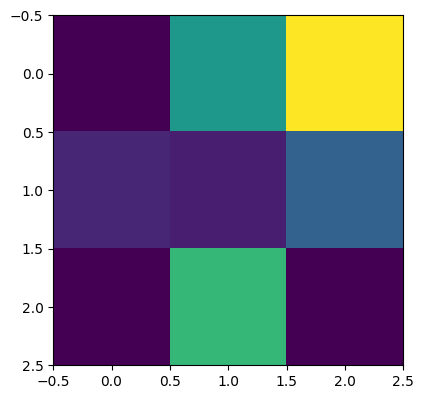

In [152]:
%matplotlib inline
print(heatmap.shape)
plt.figure(figsize=(10,10))
for ii, _ in enumerate(range(0,2,4)):
    plt.subplot(2,2,ii+1)
    plt.imshow(heatmap[0])
    plt.imshow(heatmap[1])

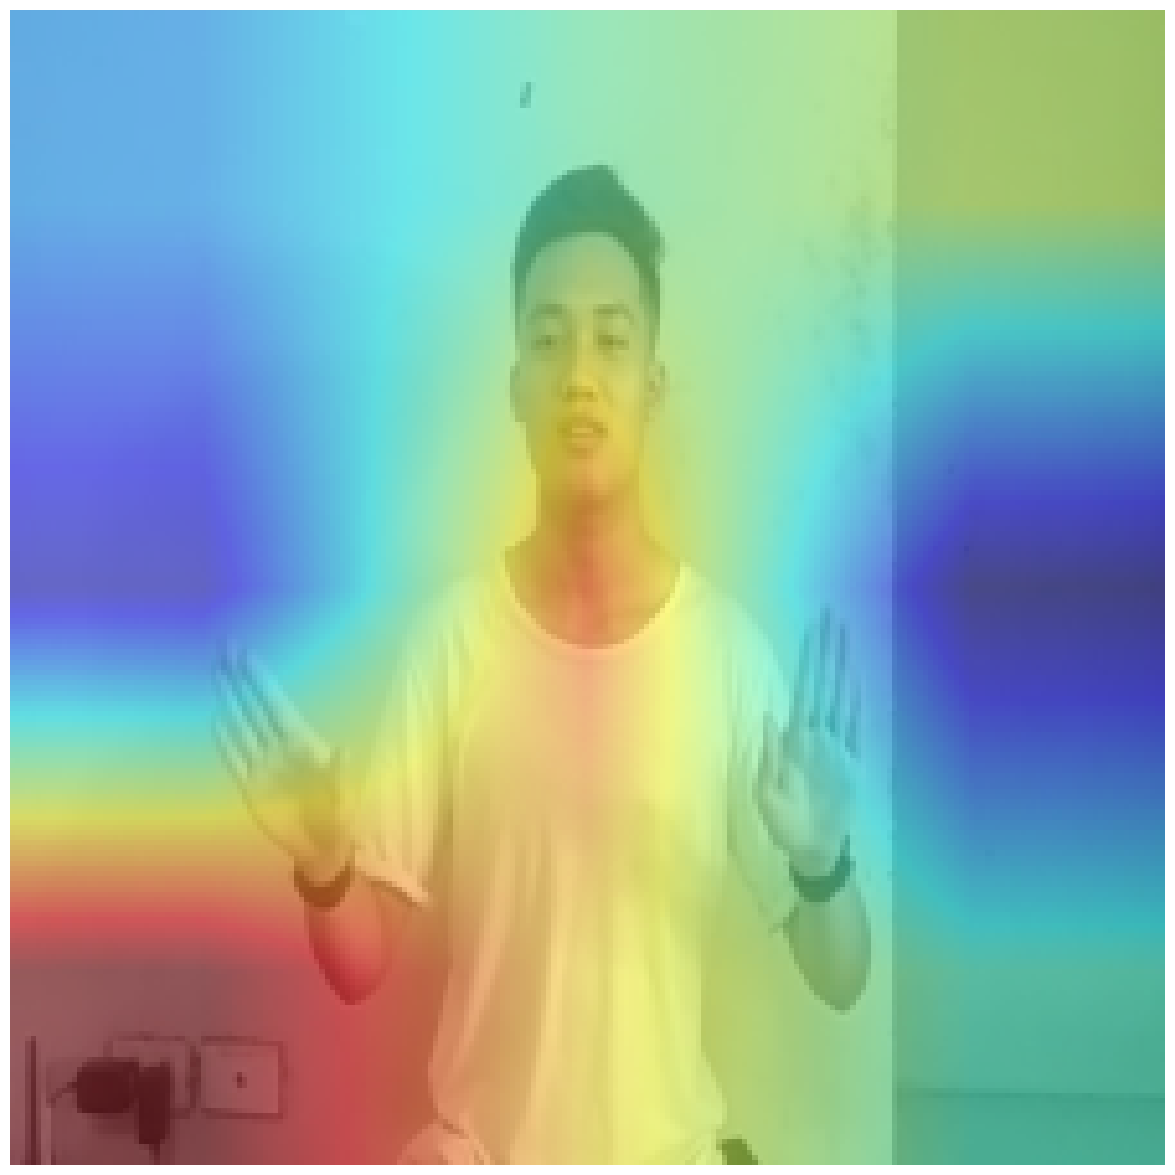

In [158]:
import cv2
import matplotlib
from torchvision.transforms.functional import to_pil_image
# imgs = xb[0]
# label = yb[0]
%matplotlib inline

plt.figure(figsize=(15,15))
x = 0.004
# for ii,img in enumerate(imgs[8::2]):
count = 0

img_ = origin_images[13]
#     plt.subplot(2,25i+1)
heatmap_ = cv2.resize(heatmap[0], (img_.shape[1], img_.shape[0]))
heatmap_ = np.uint8(255 * (1-heatmap_))
heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)

superimposed_img = heatmap_ * 0.8 + img_
superimposed_img = superimposed_img/np.max(superimposed_img)
#     cv2.imwrite('./map.jpg', superimposed_img)
plt.axis('off')
plt.imshow(superimposed_img)
    # plt.title(idx_to_label_dict[label.item()])
#     plt.colorbar()
plt.savefig('with_attention_2_.png')